This Data Science project serves the purpose to document my programming skills and my knowledge in quantitative analysis of data (including data cleaning, data visualization, data mining).

I have collected macroeconomic data for all german districts from the Federal Statistical Office and websites of other authorities, including the election results of the last Bundestag election. 
In the next step I have read and cleaned the data. Afterwards I created some descriptive statistics and in the last step I applied several advanced statistical machine learning algorithms to classify the best party in each constituency.

Timo Loos

In [1]:
#import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn import tree, naive_bayes, svm, neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim

variable names:

cases_att_civ_serv : cases of civil servants getting attacked
cases_arson: cases of arson
cases_mord: cases of murder
cases_opnv: cases of violations against the transport agent act
cases_totalcrim: cases of any crime (except of violations against the asylum act)
closed_cases_totalcrim: closed of any crime (except of violations against the asylum act)
non_german_totalcrim: cases of any crime (except of violations against the asylum act) committed by non-germans
cases_asylcrim: cases of violations against the asylum act
preisindex: price index
income: average income
employ: unemployment rate
longterm_emp: rate of longterm unemployment among unemployment
t_pop: total population
f_pop: share of women
pop_m2: population density
participation: participation rate in the election
share18: share of population under 18 years
share60: share of population older than 60
total_mig: share of migrants
f_mig: share of women among migrants
win: party with the most votes

In [2]:
#read in data
wahl = pd.read_excel('wahl.xlsx')

#rename columns
list = ["city","wahlberechtigt","participation","stimmen","union","spd","gruene","fdp","linke","afd","others"]
for i in range(0,11):
    wahl.columns.values[i+1] = list[i]

#get rid of unnecessary rows and columns
wahl=wahl.iloc[7:544,1:]

#split up string city to get pure name
df=wahl.city.str.split(',',expand=True)
wahl=wahl.assign(city=df.iloc[:,0],status=df.iloc[:,1])

#set with '-' marked missing values to NaN
wahl=wahl.replace('^-$', np.nan, regex=True)

#mark higher level districts (except of Hamburg since it is Bundesland 
#and city at once; Bremen and Berlin have multiple constituencies)
wahl.city=wahl.city.replace('Hamburg', '    Hamburg', regex=True)
wahl.city=wahl.city.replace('^(?!\s{6})', np.nan, regex=True)

#get rid of observations with too little provided information
wahl=wahl.dropna(thresh=7)

#clean off white spaces from beginning of city names
wahl.city=wahl.city.str[6:]

#get rid of the previously marked higher level districts
wahl=wahl.reset_index(drop=True)
list=[]
for i in range(0,len(wahl)):
    if wahl.city.isnull().iloc[i]:
        list+=[i]
wahl=wahl.drop(list)  
wahl=wahl.reset_index(drop=True)

#define a function to get the index of a certain city
#returns a of list of indices if there are several cities with this name
def get_city_index(city,data):
    list=[]
    for i in range(0,len(data)):
        if data.city[i]==city:
            list+=[i]
    return list

#drop Aachen, because it is also part of Städteregion Aachen
wahl=wahl.drop(get_city_index('Aachen',wahl)[0])
wahl=wahl.reset_index(drop=True)

#set NaN in status to global constant to ease further calculations
wahl.status=wahl.status.fillna('none')

#check if there are any missing values in target columns
wahl.isnull().sum()

city              0
wahlberechtigt    0
participation     0
stimmen           0
union             0
spd               0
gruene            7
fdp               0
linke             0
afd               0
others            0
status            0
dtype: int64

In [3]:
#set missing values for the party 'gruene' to zero, 
#because they lost all their votes after a lawsuit in Saarland
#since I am interested in voting behaviour it is not want I ideally want, 
#but the Gruene had not much votes in any of the constituencies
#so it does not effect my analysis
wahl.gruene=wahl.gruene.fillna(0)

In [4]:
#read in the data
mig=pd.read_csv('foreigners.csv')

#get rid of unnecessary rows and columns
mig=mig.iloc[:,1:8]

#rename columns
mig.columns.values[0]='city'
mig.columns.values[1]='x'
mig.columns.values[2]='y'
mig.columns.values[3]='z'
mig.columns.values[4]='total_mig'
mig.columns.values[5]='m_mig'
mig.columns.values[6]='f_mig'
mig=mig.reset_index(drop=True)

#drop more unnecessary columns
mig=mig.drop(['x','y','z'],axis=1)

#split up string city to get the pure name
df=mig.city.str.split(',',expand=True)
mig=mig.assign(city=df.iloc[:,0],status=df.iloc[:,1])

#set NaN in status to global constant to ease further calculations
mig.status=mig.status.fillna('none')

#checking if there are any missing values in target columns
mig.isnull().sum()

city         0
total_mig    0
m_mig        0
f_mig        0
status       0
dtype: int64

In [5]:
#preprocess data for age groups under 18, 
#between 60 and 70, between 70 and 80 and older than 80

#read in the data
pop18=pd.read_csv('pop18.csv', sep=';')

#get rid of unnecessary rows and columns
pop18=pop18.iloc[:,2:]

#rename columns
pop18.columns.values[0]='city'
pop18.columns.values[1]='total18'
pop18.columns.values[2]='abs18'
pop18.columns.values[3]='share18'
pop18=pop18.reset_index(drop=True)

#split up string city to get the pure name
df=pop18.city.str.split(',',expand=True)
pop18=pop18.assign(city=df.iloc[:,0],status=df.iloc[:,1])

#set NaN in status to global constant to ease further calculations
pop18.status=pop18.status.fillna('none')


#read in the data
pop60=pd.read_csv('pop60.csv', sep=';')

#get rid of unnecessary rows and columns
pop60=pop60.iloc[:,2:]

#rename columns
pop60.columns.values[0]='city'
pop60.columns.values[1]='total60'
pop60.columns.values[2]='abs60'
pop60.columns.values[3]='share60'
pop60=pop60.reset_index(drop=True)

#split up string city to get the pure name
df=pop60.city.str.split(',',expand=True)
pop60=pop60.assign(city=df.iloc[:,0],status=df.iloc[:,1])

#set NaN in status to global constant to ease further calculations
pop60.status=pop60.status.fillna('none')


#read in the data
pop70=pd.read_csv('pop70.csv', sep=';')

#get rid of unnecessary rows and columns
pop70=pop70.iloc[:,2:]

#rename columns
pop70.columns.values[0]='city'
pop70.columns.values[1]='total70'
pop70.columns.values[2]='abs70'
pop70.columns.values[3]='share70'
pop70=pop70.reset_index(drop=True)

#split up string city to get the pure name
df=pop70.city.str.split(',',expand=True)
pop70=pop70.assign(city=df.iloc[:,0],status=df.iloc[:,1])

#set NaN in status to global constant to ease further calculations
pop70.status=pop70.status.fillna('none')


#read in the data
pop80=pd.read_csv('pop80.csv', sep=';')

#get rid of unnecessary rows and columns
pop80=pop80.iloc[:,2:]

#rename columns
pop80.columns.values[0]='city'
pop80.columns.values[1]='total80'
pop80.columns.values[2]='abs80'
pop80.columns.values[3]='share80'
pop80=pop80.reset_index(drop=True)

#split up string city to get the pure name
df=pop80.city.str.split(',',expand=True)
pop80=pop80.assign(city=df.iloc[:,0],status=df.iloc[:,1])

#set NaN in status to global constant to ease further calculations
pop80.status=pop80.status.fillna('none')

In [6]:
#checking if there are any missing values in target columns
pop18.isnull().sum()

city       0
total18    0
abs18      0
share18    0
status     0
dtype: int64

In [7]:
#checking if there are any missing values in target columns
pop60.isnull().sum()

city       0
total60    0
abs60      0
share60    0
status     0
dtype: int64

In [8]:
#checking if there are any missing values in target columns
pop70.isnull().sum()

city       0
total70    0
abs70      0
share70    0
status     0
dtype: int64

In [9]:
#checking if there are any missing values in target columns
pop80.isnull().sum()

city       0
total80    0
abs80      0
share80    0
status     0
dtype: int64

In [10]:
#read in the data
emp=pd.read_csv('employ.csv', names=('city','z'))

#split up the column
emp[['city','employ','x','y','longterm_emp']] = emp['city'].str.split(';',expand=True)

#drop unnecessary columns
emp=emp.drop(['x', 'y','z'], axis=1)

#split up city to get pure names
df=emp.city.str.split(',',expand=True)
emp=emp.assign(city=df.iloc[:,0],status=df.iloc[:,1])

#clean out unnecessary characters from columns
emp.employ = emp.employ.str[1:-1]
emp.longterm_emp = emp.longterm_emp.str[1:-1]

#set NaN in status to global constant to ease further calculations
emp.status=emp.status.fillna('none')

#checking if there are any missing values in target columns
emp.isnull().sum()

city            0
employ          0
longterm_emp    0
status          0
dtype: int64

In [11]:
#read in the data
xls = pd.ExcelFile('income.xlsx')
inc = pd.read_excel(xls, 1)

#get rid of unnecessary rows and columns
inc=inc.iloc[6:407,[0,2,3]]

#rename columns
inc.columns.values[0]='city'
inc.columns.values[1]='preisindex'
inc.columns.values[2]='income'
inc=inc.reset_index(drop=True)

#split up string city to get the pure name
df=inc.city.str.split(',',expand=True)
inc=inc.assign(city=df.iloc[:,0],status=df.iloc[:,1])

#set NaN in status to global constant to ease further calculations
inc.status=inc.status.fillna('none')

#checking if there are any missing values in target columns
inc.isnull().sum()

city          0
preisindex    0
income        0
status        0
dtype: int64

In [12]:
#read in data
krim=pd.read_excel('krimi.xlsx')
krim=krim.iloc[8:,[1,3,4,5,12,17]]

#rename columns
krim.columns.values[0]='typ'
krim.columns.values[1]='city'
krim.columns.values[2]='status'
krim.columns.values[3]='cases'
krim.columns.values[4]='closed_cases'
krim.columns.values[5]='non_german'
krim=krim.reset_index(drop=True)

#set NaN in status to global constant to ease further calculations
krim.status=krim.status.fillna('none')

#extract data for various interesting types of crime to seperate tables
mord=pd.DataFrame()
for i in range(0,len(krim)):
    if bool(re.search('Mord,\sTotschlag\sund\sTötung\sauf\sVerlangen', krim.at[i,'typ'])):
        mord=pd.concat([mord,krim.iloc[[i]]])
strcrim=pd.DataFrame()
for i in range(0,len(krim)):
    if bool(re.search('Straßenkriminalität', krim.at[i,'typ'])):
        strcrim=pd.concat([strcrim,krim.iloc[[i]]])
viocrim=pd.DataFrame()
for i in range(0,len(krim)):
    if bool(re.search('Gewaltkriminalität', krim.at[i,'typ'])):
        viocrim=pd.concat([viocrim,krim.iloc[[i]]])
totalcrim=pd.DataFrame()
for i in range(0,len(krim)):
    if bool(re.search('Straftaten insgesamt, jedoch ohne Verstöße gegen', krim.at[i,'typ'])):
        totalcrim=pd.concat([totalcrim,krim.iloc[[i]]])
asylcrim=pd.DataFrame()
for i in range(0,len(krim)):
    if bool(re.search('Straftaten gegen das Aufenthalts', krim.at[i,'typ'])):
        asylcrim=pd.concat([asylcrim,krim.iloc[[i]]])
arson=pd.DataFrame()
for i in range(0,len(krim)):
    if bool(re.search('Brandstiftung und Herbeiführen einer Brandgefahr', krim.at[i,'typ'])):
        arson=pd.concat([arson,krim.iloc[[i]]])
att_civ_serv=pd.DataFrame()
for i in range(0,len(krim)):
    if bool(re.search('Tätlicher Angriff auf Vollstreckungsbeamte und gleichstehende Personen', krim.at[i,'typ'])):
        att_civ_serv=pd.concat([att_civ_serv,krim.iloc[[i]]])
opnv=pd.DataFrame()
for i in range(0,len(krim)):
    if bool(re.search('Beförderungserschleichung', krim.at[i,'typ'])):
        opnv=pd.concat([opnv,krim.iloc[[i]]])
assault=pd.DataFrame()
for i in range(0,len(krim)):
    if bool(re.search('Gefährliche und schwere Körperverletzung', krim.at[i,'typ'])):
        assault=pd.concat([assault,krim.iloc[[i]]])
        
#delete unnecessary columns
mord=mord.reset_index(drop=True)
del mord['typ']
arson=arson.reset_index(drop=True)
del arson['typ']
assault=assault.reset_index(drop=True)
del assault['typ']
att_civ_serv=att_civ_serv.reset_index(drop=True)
del att_civ_serv['typ']
opnv=opnv.reset_index(drop=True)
del opnv['typ']
asylcrim=asylcrim.reset_index(drop=True)
del asylcrim['typ']
totalcrim=totalcrim.reset_index(drop=True)
del totalcrim['typ']
strcrim=strcrim.reset_index(drop=True)
del strcrim['typ']
viocrim=viocrim.reset_index(drop=True)
del viocrim['typ']

#rename columns
mord.columns.values[2]='cases_mord'
mord.columns.values[3]='closed_cases_mord'
mord.columns.values[4]='non_german_mord'
viocrim.columns.values[2]='cases_viocrim'
viocrim.columns.values[3]='closed_cases_viocrim'
viocrim.columns.values[4]='non_german_viocrim'
strcrim.columns.values[2]='cases_strcrim'
strcrim.columns.values[3]='closed_cases_strcrim'
strcrim.columns.values[4]='non_german_strcrim'
totalcrim.columns.values[2]='cases_totalcrim'
totalcrim.columns.values[3]='closed_cases_totalcrim'
totalcrim.columns.values[4]='non_german_totalcrim'
asylcrim.columns.values[2]='cases_asylcrim'
asylcrim.columns.values[3]='closed_cases_asylcrim'
asylcrim.columns.values[4]='non_german_asylcrim'
opnv.columns.values[2]='cases_opnv'
opnv.columns.values[3]='closed_cases_opnv'
opnv.columns.values[4]='non_german_opnv'
assault.columns.values[2]='cases_assault'
assault.columns.values[3]='closed_cases_assault'
assault.columns.values[4]='non_german_assault'
arson.columns.values[2]='cases_arson'
arson.columns.values[3]='closed_cases_arson'
arson.columns.values[4]='non_german_arson'
att_civ_serv.columns.values[2]='cases_att_civ_serv'
att_civ_serv.columns.values[3]='closed_cases_att_civ_serv'
att_civ_serv.columns.values[4]='non_german_att_civ_serv'

In [13]:
#for some cities the number of cases is so low that the share of 
#non_germans and closed_cases contributing to 
#this statistic is not meaningful in any sense.
#therefor I decide to set non_german and closed_cases respectively 
#to NaN if number of cases is less than 30
#if I have strong enough information in less than 95% of cities, than I 
#will exclude columns non_german and closed_cases for that type of crime 
listOfColumns=[mord,att_civ_serv,arson,assault,opnv,asylcrim,strcrim,totalcrim,viocrim]
for things in listOfColumns:
    for i in range(0,len(mord)):
        if things.iloc[i,2]<30:
            things.iloc[i,3]=np.nan
            things.iloc[i,4]=np.nan

In [14]:
#I check for enough support (95%) in closed_cases and non_german
#5%: len(table)-0.95*len(table)=25.05
#so if more than 25 missing values in a column, then I'll exclude it

#check for NaN
opnv.isnull().sum()

city                  0
status                0
cases_opnv            0
closed_cases_opnv    67
non_german_opnv      67
dtype: int64

In [15]:
#not enough support in data, so I exclude the columns from my analysis
del opnv['non_german_opnv']
del opnv['closed_cases_opnv']

In [16]:
#check for NaN
viocrim.isnull().sum()

city                    0
status                  0
cases_viocrim           0
closed_cases_viocrim    0
non_german_viocrim      0
dtype: int64

In [17]:
#check for NaN
mord.isnull().sum()

city                   0
status                 0
cases_mord             0
closed_cases_mord    394
non_german_mord      394
dtype: int64

In [18]:
#not enough support in data, so I exclude the columns from my analysis
del mord['non_german_mord']
del mord['closed_cases_mord']

In [19]:
#check for NaN
strcrim.isnull().sum()

city                    0
status                  0
cases_strcrim           0
closed_cases_strcrim    0
non_german_strcrim      0
dtype: int64

In [20]:
#check for NaN
totalcrim.isnull().sum()

city                      0
status                    0
cases_totalcrim           0
closed_cases_totalcrim    0
non_german_totalcrim      0
dtype: int64

In [21]:
#check for NaN
att_civ_serv.isnull().sum()

city                           0
status                         0
cases_att_civ_serv             0
closed_cases_att_civ_serv    252
non_german_att_civ_serv      252
dtype: int64

In [22]:
#not enough support in data, so I exclude the columns from my analysis
del att_civ_serv['non_german_att_civ_serv']
del att_civ_serv['closed_cases_att_civ_serv']

In [23]:
#check for NaN
arson.isnull().sum()

city                    0
status                  0
cases_arson             0
closed_cases_arson    193
non_german_arson      193
dtype: int64

In [24]:
#not enough support in data, so I exclude the columns from my analysis
del arson['non_german_arson']
del arson['closed_cases_arson']

In [25]:
#check for NaN
assault.isnull().sum()

city                    0
status                  0
cases_assault           0
closed_cases_assault    2
non_german_assault      2
dtype: int64

skewness: -0.019712872915100578
kurtosis: -0.248854550450071


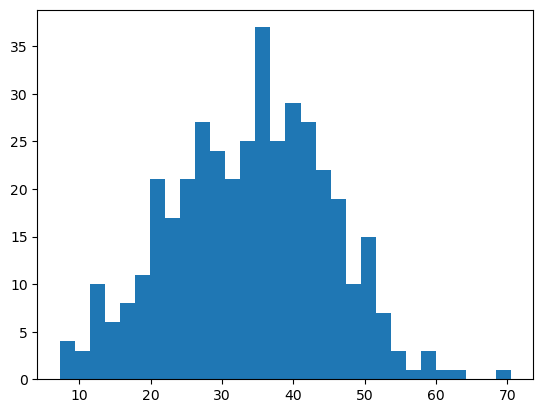

In [26]:
#enough support, though few missing values have to be handled
#histogram, skewness and kurtosis don't detect any anomalies 
#in the distribution of non_germans
plt.hist(assault.non_german_assault,bins=30)
print('skewness:',assault.non_german_assault.skew())
print('kurtosis:',assault.non_german_assault.kurtosis())

In [27]:
#therefore, I opt for filling missing values with the expected value
mean=assault.non_german_assault.mean()
for i in range(0,len(mord)):
    assault.non_german_assault=assault.non_german_assault.fillna(mean)

skewness: -0.6525305787808358
kurtosis: 0.7946746958316853


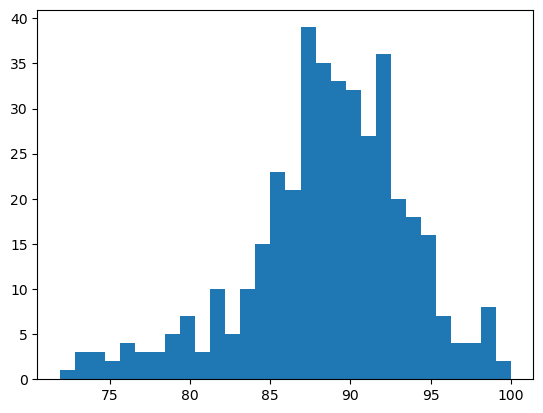

In [28]:
#enough support, though few missing values have to be handled
#histogram, skewness and kurtosis don't detect severe 
#anomalies (slightly leptocurtic) in the distribution of closed_cases
plt.hist(assault.closed_cases_assault,bins=30)
print('skewness:',assault.closed_cases_assault.skew())
print('kurtosis:',assault.closed_cases_assault.kurtosis())

In [29]:
#therefore, I opt for filling missing values with the expected value
mean=assault.closed_cases_assault.mean()
for i in range(0,len(mord)):
    assault.closed_cases_assault=assault.closed_cases_assault.fillna(mean)

In [30]:
#check for NaN
asylcrim.isnull().sum()

city                      0
status                    0
cases_asylcrim            0
closed_cases_asylcrim    95
non_german_asylcrim      95
dtype: int64

In [31]:
#not enough support in data, so I exclude the columns from my analysis
del asylcrim['non_german_asylcrim']
del asylcrim['closed_cases_asylcrim']

In [32]:
#read in data
xls = pd.ExcelFile('city.xlsx')
cities = pd.read_excel(xls, 1)

#get rid of unnecessary rows and columns
cities=cities.iloc[7:476,1:]

#rename columns
cities.columns.values[0]='status'
cities.columns.values[1]='city'
cities.columns.values[2]='x'
cities.columns.values[3]='area'
cities.columns.values[4]='t_pop'
cities.columns.values[5]='m_pop'
cities.columns.values[6]='f_pop'
cities.columns.values[7]='pop_m2'

#get rid of more unnecessary rows and columns
cities=cities.reset_index(drop=True)
list=[]
for i in range(0,len(cities)):
    if cities.x.isnull().iloc[i]:
        list+=[i]
cities=cities.drop(list)
del cities['m_pop']
del cities['x']
cities=cities.reset_index(drop=True)

#split up column city to get pure name
df=cities.city.str.split(',',expand=True)
cities=cities.assign(city=df.iloc[:,0])

#check if there are any missing values
cities.isnull().sum()

status    0
city      0
area      0
t_pop     0
f_pop     0
pop_m2    0
dtype: int64

In [33]:
#define function to join two datasets based on their city name
#in case a name occurs more than once, the join is 
#based on the type of the district (status), therefore the two regex arguments
#since in Germany there are basically two types of districts on that 
#level: either normal districts like Landkreis or independent cities
#that is why names can occur twice, if the Landkreis is named after 
#the biggest city surrounding it
#returns the merged dataset and the input datasets with only the remaining 
#cities, so for those who didn't match to any cities of the other dataset
def merge_data(data1,data2,regex1,regex2):
    length=len(data1)
    list1=[]
    list2=[]
    merge=pd.DataFrame()
    for i in range(0,len(data1)):
        for j in range(0,len(data2)):
            if data1.at[i,'city']==data2.at[j,'city']:
                if data1.at[i,'status']==data2.at[j,'status'] or (data1.duplicated(subset=['city'], keep=False).iloc[i]==False and data2.duplicated(subset=['city'], keep=False).iloc[j]==False) or ((data1.duplicated(subset=['city'], keep=False).iloc[i] or data2.duplicated(subset=['city'], keep=False).iloc[j]) and (bool(re.search(regex1, data1.at[i,'status'])) and bool(re.search(regex1, data2.at[j,'status']))) or (bool(re.search(regex2, data1.at[i,'status'])) and bool(re.search(regex2, data2.at[j,'status'])))):
                    tmp1 = pd.DataFrame(data=data1.iloc[[i]])
                    tmp1=tmp1.reset_index(drop=True)
                    tmp2 = pd.DataFrame(data=data2.iloc[[j]])
                    tmp2=tmp2.reset_index(drop=True)
                    del tmp2['city']
                    del tmp2['status']
                    merge=pd.concat([merge, pd.concat([tmp1, tmp2], axis=1)], ignore_index=True)
                    list1+=[i]
                    list2+=[j]
    data1=data1.drop(list1)
    data2=data2.drop(list2)
    data1new=data1.reset_index(drop=True)
    data2new=data2.reset_index(drop=True)
    if len(data1new)<length:
        a,data1new,data2new=merge_data(data1new,data2new,regex1,regex2)
        merge=pd.concat([merge, a], ignore_index=True)
    return merge,data1new,data2new

In [34]:
#define function that checks how similar two given strings are
#it gives rewards, when chain of letters occur in both input strings
#returns the received score
def similar(txt1,txt2,c=False):
    reward=0
    if txt1==txt2:
        reward=10**20
    for i in range(0,len(txt1)):
        list=[]
        for j, char in enumerate(txt2):
            if txt1[i] in char:
                list+=[j]
        while len(list) > 0:
            t=list[0]
            list.pop()
            q=1
            while i+q<len(txt1) and t+q<len(txt2) and txt1[i+q] == txt2[t+q]:
                reward+=q
                q+=1
    if c==False:
        reward+=similar(txt2,txt1,True)
    return reward

#define function to get for c the most similar string from city_list
#returns the most similar string, the received score and 
#the respective index in the city_list
def most_similar(c,city_list):
    score=0
    for j in range(0,len(city_list)):
        if similar(c,city_list[j])>score:
            score=similar(c,city_list[j])
            guess=city_list[j]
            ind=j
    return guess,score,ind

#define function to get for two datasets for every object in column city
#the most similar city in the other dataset
#counts only if one string is the most similar to the other and vice versa
#otherwise just puts a 'none' as most similar
#retruns dataset with two columns with the detected similar city names
def find_city(data1,data2):
    list1=[]
    list2=[]
    for i in range(0,len(data1)):
        guess1,score1,ind1=most_similar(data1.city[i],data2.city)
        if score1>25:
            guess2,score2,ind2=most_similar(data2.city[ind1],data1.city)
            if score2>25:
                if guess2==data1.city[i] and guess1==data2.city[ind1]:
                    list1+=[guess1]
                else:
                    list1+=['none']
            else:
                list1+=['none']
        else:
            list1+=['none']
        list2+=[data1.city[i]]
    dict={'c1':list2,'c2':list1}
    tmp=pd.DataFrame(data=dict)
    return tmp

In [35]:
#define function that does the same as merge_data
#only this time it is thought to be done on the remaining cities,
#say, those who didn't match in the first round
#find_city provides a table of matching city names, based on which this 
#function joins data1 and data2 and appends to the 
#already merged data merge_data
def checked_merge(merge_data,data1,data2,check):
    list1=[]
    list2=[]
    merge=pd.DataFrame(data=merge_data)
    for i in range(0,len(check)):
        if check.c2[i]!='none':
            tmp1 = pd.DataFrame(data=data1.iloc[get_city_index(check.c1[i],data1)[0]])
            tmp1=tmp1.transpose()
            tmp1=tmp1.reset_index(drop=True)
            tmp2 = pd.DataFrame(data=data2.iloc[get_city_index(check.c2[i],data2)[0]])
            tmp2=tmp2.transpose()
            tmp2=tmp2.reset_index(drop=True)
            del tmp2['city']
            del tmp2['status']
            merge=pd.concat([merge, pd.concat([tmp1, tmp2], axis=1)], ignore_index=True)
            list1+=[get_city_index(check.c1[i],data1)[0]]
            list2+=[get_city_index(check.c2[i],data2)[0]]
    data1=data1.drop(list1)
    data2=data2.drop(list2)
    data1=data1.reset_index(drop=True)
    data2=data2.reset_index(drop=True)
    return merge,data1,data2

In [36]:
#get unique values for status
mord.status.unique()

array(['KfS', 'K', 'LK', 'SK', 'RV'], dtype=object)

In [37]:
#get unique values for status
inc.status.unique()

array([' Kreisfreie Stadt', ' Landeshauptstadt', ' Hansestadt', ' Kreis',
       'none', ' Landkreis', ' Wissenschaftsstadt', ' documenta-Stadt',
       ' Stadtkreis', ' Universitätsstadt', ' Regionalverband',
       ' Kreisfreie Stadt1)'], dtype=object)

In [38]:
#get unique values for status
mig.status.unique()

array([' Stadt', 'none', ' Stadtverband'], dtype=object)

In [39]:
#get unique values for status
pop18.status.unique()

array(['Stadt', 'none', 'Landkreis'], dtype=object)

In [40]:
#get unique values for status
wahl.status.unique()

array([' kreisfreie Stadt', ' Landeshauptstadt', ' Hansestadt',
       ' Landkreis', 'none', ' Kreis', ' Universitätsstadt',
       ' Stadtkreis', ' Regionalverband', ' Hanse- und Universitätsstadt',
       ' Stadt'], dtype=object)

In [41]:
#get unique values for status
cities.status.unique()

array(['Kreisfreie Stadt', 'Kreis', 'Landkreis', 'Stadtkreis',
       'Regionalverband'], dtype=object)

In [42]:
#get unique values for status
emp.status.unique()

array(['none', ' Stadt', ' Wissenschaftsstadt', ' kreisfreie Stadt',
       ' Stadt der FernUniversität', ' Freie und Hansestadt',
       ' Universitätsstadt', ' documenta-Stadt', ' Landeshauptstadt',
       ' Hansestadt', ' Hanse- und Universitätsstadt', ' Klingenstadt'],
      dtype=object)

In [43]:
#from all unique values I build the two regular expressions
#one for the Landkreis the other for the cities
regex1='^KfS$|^SK$|[sS]tadt'
regex2='^LK$|^K$|^RV$|Kreis$|ndkreis|egionalverband'

In [44]:
#joining all datasets from the crime dataset
merge, viocrim, att_civ_serv=merge_data(viocrim,att_civ_serv,regex1,regex2)
merge, x, strcrim=merge_data(merge,strcrim,regex1,regex2)
merge, x, arson=merge_data(merge,arson,regex1,regex2)
merge, x, assault=merge_data(merge,assault,regex1,regex2)
merge, x, mord=merge_data(merge,mord,regex1,regex2)
merge, x, opnv=merge_data(merge,opnv,regex1,regex2)
merge, x, totalcrim=merge_data(merge,totalcrim,regex1,regex2)
merge, x, asylcrim=merge_data(merge,asylcrim,regex1,regex2)

In [45]:
#check if all rows were merged
mord

,city,status,cases_mord


In [46]:
#join the merged data with income
merge, old_merge, inc=merge_data(merge,inc,regex1,regex2)

In [47]:
#check if all rows were merged
old_merge

,city,status,cases_viocrim,closed_cases_viocrim,non_german_viocrim,cases_att_civ_serv,cases_strcrim,closed_cases_strcrim,non_german_strcrim,cases_arson,cases_assault,closed_cases_assault,non_german_assault,cases_mord,cases_opnv,cases_totalcrim,closed_cases_totalcrim,non_german_totalcrim,cases_asylcrim
0,Aachen,K,1520,76.4,35.8,52,10201,14.1,32.2,153,1104,82.5,34.6,4,2391,40931,52.4,33.5,2169
1,Regionalverband Saarbrücken,RV,957,81.4,41.1,85,4718,20.4,39.6,122,733,85.7,40.4,13,528,24260,59.8,32,812


In [48]:
#check if all rows were merged
inc

,city,preisindex,income,status
0,Städteregion Aachen,101.52,25852.775571,Kreis
1,Saarbrücken,101.22,23482.489953,Regionalverband


In [49]:
#since not all rows could be merged I try to match them based on 
#similarity of their names
tmp=find_city(old_merge,inc)
#check manually if the algorithm correctly assigned most similar cities
tmp

,c1,c2
0,Aachen,Städteregion Aachen
1,Regionalverband Saarbrücken,Saarbrücken


In [50]:
#it did, so I merge
merge,old_merge,inc=checked_merge(merge,old_merge,inc,tmp)

In [51]:
#join the merged data with employment
merge,old_merge,emp=merge_data(merge,emp,regex1,regex2)

In [52]:
#check if all rows were merged
old_merge

,city,status,cases_viocrim,closed_cases_viocrim,non_german_viocrim,cases_att_civ_serv,cases_strcrim,closed_cases_strcrim,non_german_strcrim,cases_arson,...,closed_cases_assault,non_german_assault,cases_mord,cases_opnv,cases_totalcrim,closed_cases_totalcrim,non_german_totalcrim,cases_asylcrim,preisindex,income
0,Eisenach,KfS,69,87,31.5,3,397,38,19.3,19,...,88.0,34.5,1,111,3018,67.8,20.2,3,94.46,21746.01749
1,Aachen,K,1520,76.4,35.8,52,10201,14.1,32.2,153,...,82.5,34.6,4,2391,40931,52.4,33.5,2169,101.52,25852.775571


In [53]:
#check if all rows were merged
emp

,city,employ,longterm_emp,status
0,Städteregion Aachen,22.610,40,none


In [54]:
#since not all rows could be merged I try to match them based on 
#similarity of their names
tmp=find_city(old_merge,emp)
#check manually if the algorithm correctly assigned most similar cities
tmp

,c1,c2
0,Eisenach,none
1,Aachen,Städteregion Aachen


In [55]:
#it did, so I merge (although only for Aachen)
merge,old_merge,emp=checked_merge(merge,old_merge,emp,tmp)

In [56]:
#check if all rows were merged
emp

,city,employ,longterm_emp,status


In [57]:
#check if all rows were merged
old_merge

,city,status,cases_viocrim,closed_cases_viocrim,non_german_viocrim,cases_att_civ_serv,cases_strcrim,closed_cases_strcrim,non_german_strcrim,cases_arson,...,closed_cases_assault,non_german_assault,cases_mord,cases_opnv,cases_totalcrim,closed_cases_totalcrim,non_german_totalcrim,cases_asylcrim,preisindex,income
0,Eisenach,KfS,69,87,31.5,3,397,38,19.3,19,...,88.0,34.5,1,111,3018,67.8,20.2,3,94.46,21746.01749


In [58]:
#Eisenach got attached to Wartburgkreis in 2021
#so I combine all values of Wartburgkreis and Eisenach
get_city_index('Wartburgkreis',merge)[0]

362

In [59]:
#while combining, attention needs to be paid to the type of values
#for some it is okay to just sum them up, others are percentages
merge.loc[362,'cases_viocrim']+=old_merge.loc[0,'cases_viocrim']
merge.loc[362,'cases_opnv']+=old_merge.loc[0,'cases_opnv']
merge.loc[362,'cases_mord']+=old_merge.loc[0,'cases_mord']
merge.loc[362,'cases_arson']+=old_merge.loc[0,'cases_arson']
merge.loc[362,'cases_assault']+=old_merge.loc[0,'cases_assault']
merge.loc[362,'cases_strcrim']+=old_merge.loc[0,'cases_strcrim']
merge.loc[362,'cases_totalcrim']+=old_merge.loc[0,'cases_totalcrim']
merge.loc[362,'cases_asylcrim']+=old_merge.loc[0,'cases_asylcrim']
merge.loc[362,'cases_att_civ_serv']+=old_merge.loc[0,'cases_att_civ_serv']
merge.loc[362,'preisindex']=old_merge.loc[0,'preisindex']+merge.loc[362,'preisindex']/2
merge.loc[362,'income']=old_merge.loc[0,'income']+merge.loc[362,'income']/2
merge.loc[362,'closed_cases_viocrim']=(merge.loc[362,'cases_viocrim']-old_merge.loc[0,'cases_viocrim'])*merge.loc[362,'closed_cases_viocrim']/merge.loc[362,'cases_viocrim']+old_merge.loc[0,'closed_cases_viocrim']*old_merge.loc[0,'cases_viocrim']/merge.loc[362,'cases_viocrim']
merge.loc[362,'closed_cases_strcrim']=(merge.loc[362,'cases_strcrim']-old_merge.loc[0,'cases_strcrim'])*merge.loc[362,'closed_cases_strcrim']/merge.loc[362,'cases_strcrim']+old_merge.loc[0,'closed_cases_strcrim']*old_merge.loc[0,'cases_strcrim']/merge.loc[362,'cases_strcrim']
merge.loc[362,'closed_cases_totalcrim']=(merge.loc[362,'cases_totalcrim']-old_merge.loc[0,'cases_totalcrim'])*merge.loc[362,'closed_cases_totalcrim']/merge.loc[362,'cases_totalcrim']+old_merge.loc[0,'closed_cases_totalcrim']*old_merge.loc[0,'cases_totalcrim']/merge.loc[362,'cases_totalcrim']
merge.loc[362,'closed_cases_assault']=(merge.loc[362,'cases_assault']-old_merge.loc[0,'cases_assault'])*merge.loc[362,'closed_cases_assault']/merge.loc[362,'cases_assault']+old_merge.loc[0,'closed_cases_assault']*old_merge.loc[0,'cases_assault']/merge.loc[362,'cases_assault']
merge.loc[362,'non_german_viocrim']=(merge.loc[362,'non_german_viocrim']-old_merge.loc[0,'non_german_viocrim'])*merge.loc[362,'non_german_viocrim']/merge.loc[362,'non_german_viocrim']+old_merge.loc[0,'non_german_viocrim']*old_merge.loc[0,'non_german_viocrim']/merge.loc[362,'non_german_viocrim']
merge.loc[362,'non_german_totalcrim']=(merge.loc[362,'non_german_totalcrim']-old_merge.loc[0,'non_german_totalcrim'])*merge.loc[362,'non_german_totalcrim']/merge.loc[362,'non_german_totalcrim']+old_merge.loc[0,'non_german_totalcrim']*old_merge.loc[0,'non_german_totalcrim']/merge.loc[362,'non_german_totalcrim']
merge.loc[362,'non_german_strcrim']=(merge.loc[362,'non_german_strcrim']-old_merge.loc[0,'non_german_strcrim'])*merge.loc[362,'non_german_strcrim']/merge.loc[362,'non_german_strcrim']+old_merge.loc[0,'non_german_strcrim']*old_merge.loc[0,'non_german_strcrim']/merge.loc[362,'non_german_strcrim']
merge.loc[362,'non_german_assault']=(merge.loc[362,'non_german_assault']-old_merge.loc[0,'non_german_assault'])*merge.loc[362,'non_german_assault']/merge.loc[362,'non_german_assault']+old_merge.loc[0,'non_german_assault']*old_merge.loc[0,'non_german_assault']/merge.loc[362,'non_german_assault']

In [60]:
#join the merged data with cities
merge,old_merge,cities=merge_data(merge,cities,regex1,regex2)

In [61]:
#check if all rows were merged
old_merge

,city,status,cases_viocrim,closed_cases_viocrim,non_german_viocrim,cases_att_civ_serv,cases_strcrim,closed_cases_strcrim,non_german_strcrim,cases_arson,...,cases_mord,cases_opnv,cases_totalcrim,closed_cases_totalcrim,non_german_totalcrim,cases_asylcrim,preisindex,income,employ,longterm_emp
0,Aachen,K,1520,76.4,35.8,52,10201,14.1,32.2,153,...,4,2391,40931,52.4,33.5,2169,101.52,25852.775571,22.610,40


In [62]:
#check if all rows were merged
cities

,status,city,area,t_pop,f_pop,pop_m2
0,Kreis,Städteregion Aachen,706.91,556673,275425,787


In [63]:
#since not all rows could be merged I try to match them based on 
#similarity of their names
tmp=find_city(old_merge,cities)
#check manually if the algorithm correctly assigned most similar cities
tmp

,c1,c2
0,Aachen,Städteregion Aachen


In [64]:
#it did, so I merge
merge,old_merge,cities=checked_merge(merge,old_merge,cities,tmp)

In [65]:
#join the merged data with wahl
merge,old_merge,wahl=merge_data(merge,wahl,regex1,regex2)

In [66]:
#check if all rows were merged
wahl

,city,wahlberechtigt,participation,stimmen,union,spd,gruene,fdp,linke,afd,others,status
0,Hannover,367106.0,74.3,270036.0,45947.0,79627.0,72336.0,26570.0,14599.0,14430.0,16527.0,Landeshauptstadt
1,Städteregion Aachen (einschl. Stadt Aachen),402726.0,77.1,308380.0,81610.0,83996.0,60339.0,32924.0,12712.0,17836.0,18963.0,none
2,Saarbrücken,238608.0,74.5,174835.0,36708.0,66549.0,0.0,20265.0,15638.0,16878.0,18797.0,Regionalverband
3,Saarbrücken,123995.0,72.8,89101.0,16666.0,34105.0,0.0,10610.0,9987.0,7734.0,9999.0,Landeshauptstadt
4,Berlin-Mitte,207483.0,73.5,150419.0,16856.0,32133.0,46120.0,13186.0,20820.0,7734.0,13570.0,none
5,Berlin-Friedrichshain-Kreuzberg,170553.0,78.6,132667.0,8627.0,24819.0,50544.0,7985.0,24606.0,4621.0,11465.0,none
6,Berlin-Pankow,285108.0,78.2,220358.0,24568.0,48100.0,60297.0,17484.0,31451.0,18329.0,20129.0,none
7,Berlin-Charlottenburg-Wilmersdorf,217663.0,78.1,167843.0,31477.0,40790.0,43361.0,21528.0,11018.0,8579.0,11090.0,none
8,Berlin-Spandau,159388.0,70.4,109469.0,23988.0,30429.0,15073.0,11146.0,5282.0,11575.0,11976.0,none
9,Berlin-Steglitz-Zehlendorf,217814.0,81.4,174869.0,39943.0,42910.0,39550.0,22208.0,8311.0,9915.0,12032.0,none


In [67]:
#check if all rows were merged
old_merge

,city,status,cases_viocrim,closed_cases_viocrim,non_german_viocrim,cases_att_civ_serv,cases_strcrim,closed_cases_strcrim,non_german_strcrim,cases_arson,...,non_german_totalcrim,cases_asylcrim,preisindex,income,employ,longterm_emp,area,t_pop,f_pop,pop_m2
0,Berlin,KfS,15539,65.4,45.2,1621,103953,12.6,44.2,1040,...,39.4,13025,102.56,26176.437776,183.520,32,891.12,3677472,1869646,4127
1,Nordwestmecklenburg,LK,291,85.9,13.8,38,1363,29.1,13,97,...,10.6,23,97.23,22602.702737,5.910,36,2127.07,158449,79610,74
2,Ludwigslust-Parchim,LK,301,88,21,27,1319,25.5,20.7,91,...,16.9,115,93.95,23258.097352,6.770,35,4766.81,211899,106079,44
3,Regionalverband Saarbrücken,RV,957,81.4,41.1,85,4718,20.4,39.6,122,...,32,812,101.22,23482.489953,16.250,37,410.95,327284,166141,796
4,Aachen,K,1520,76.4,35.8,52,10201,14.1,32.2,153,...,33.5,2169,101.52,25852.775571,22.610,40,706.91,556673,275425,787


In [68]:
#here I stumble across the problem, that some districts are 
#split into separate constituencies, for which it is not possible to 
#get all the other macroeconomic data, so I have to join the respective 
#constituency to the level of the district
#first for Berlin (I combine all constituencies containing 'Berlin')
tmp={'city':'Berlin', 'wahlberechtigt':0, 'participation':0, 'stimmen':0, 'union':0,'spd':0,'gruene':0,'fdp':0,'linke':0,'afd':0,'others':0,'status':'none'}
for i in range(0,len(wahl)):
    if wahl.city.str.contains('Berlin').iloc[i]:
        tmp['wahlberechtigt']+=wahl.wahlberechtigt.iloc[i]
        tmp['stimmen']+=wahl.stimmen.iloc[i]
        tmp['union']+=wahl.union.iloc[i]
        tmp['spd']+=wahl.spd.iloc[i]
        tmp['gruene']+=wahl.gruene.iloc[i]
        tmp['fdp']+=wahl.fdp.iloc[i]
        tmp['linke']+=wahl.linke.iloc[i]
        tmp['afd']+=wahl.afd.iloc[i]
        tmp['others']+=wahl.others.iloc[i]
tmp['participation']=tmp['stimmen']/tmp['wahlberechtigt']
tmp=pd.DataFrame(data=tmp, index=[0])
wahl=pd.concat([wahl, tmp], ignore_index=True)
#second for Regionalverband Saarbrücken (I combine all constituencies 
#containing 'Saarbrücken')
tmp={'city':'Regionalverband Saarbrücken', 'wahlberechtigt':0, 'participation':0, 'stimmen':0, 'union':0,'spd':0,'gruene':0,'fdp':0,'linke':0,'afd':0,'others':0,'status':'none'}
for i in range(0,len(wahl)):
    if wahl.city.str.contains('Saarbrücken').iloc[i]:
        tmp['wahlberechtigt']+=wahl.wahlberechtigt.iloc[i]
        tmp['stimmen']+=wahl.stimmen.iloc[i]
        tmp['union']+=wahl.union.iloc[i]
        tmp['spd']+=wahl.spd.iloc[i]
        tmp['gruene']+=wahl.gruene.iloc[i]
        tmp['fdp']+=wahl.fdp.iloc[i]
        tmp['linke']+=wahl.linke.iloc[i]
        tmp['afd']+=wahl.afd.iloc[i]
        tmp['others']+=wahl.others.iloc[i]
tmp['participation']=tmp['stimmen']/tmp['wahlberechtigt']
tmp=pd.DataFrame(data=tmp, index=[0])
wahl=pd.concat([wahl, tmp], ignore_index=True)
#third for Hannover, but while one constituency matched, the other did not
#so I have to find out the name of the one that matched
for i in range(0,len(merge)):
    if merge.city.str.contains('Hannover').iloc[i]:
        print(merge.iloc[i,0])

Region Hannover


In [69]:
#combine Region Hannover with Hannover
merge.wahlberechtigt.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.wahlberechtigt.iloc[get_city_index('Hannover',wahl)[0]]
merge.stimmen.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.stimmen.iloc[get_city_index('Hannover',wahl)[0]]
merge.union.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.union.iloc[get_city_index('Hannover',wahl)[0]]
merge.spd.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.spd.iloc[get_city_index('Hannover',wahl)[0]]
merge.gruene.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.gruene.iloc[get_city_index('Hannover',wahl)[0]]
merge.fdp.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.fdp.iloc[get_city_index('Hannover',wahl)[0]]
merge.linke.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.linke.iloc[get_city_index('Hannover',wahl)[0]]
merge.afd.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.afd.iloc[get_city_index('Hannover',wahl)[0]]
merge.others.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.others.iloc[get_city_index('Hannover',wahl)[0]]
merge.participation.iloc[get_city_index('Region Hannover',merge)[0]]=merge.stimmen.iloc[get_city_index('Region Hannover',merge)[0]]/merge.wahlberechtigt.iloc[get_city_index('Region Hannover',merge)[0]]

/var/folders/5r/l5391v2x4hb022ty7xphstrm0000gn/T/ipykernel_54650/4034289317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge.wahlberechtigt.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.wahlberechtigt.iloc[get_city_index('Hannover',wahl)[0]]
/var/folders/5r/l5391v2x4hb022ty7xphstrm0000gn/T/ipykernel_54650/4034289317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge.stimmen.iloc[get_city_index('Region Hannover',merge)[0]]+=wahl.stimmen.iloc[get_city_index('Hannover',wahl)[0]]
/var/folders/5r/l5391v2x4hb022ty7xphstrm0000gn/T/ipykernel_54650/4034289317.py:4: SettingWithCopyWarning: 
A value is tr

In [70]:
#now I try to match them based on 
#similarity of their names
tmp=find_city(old_merge,wahl)
#check manually if the algorithm correctly assigned most similar cities
tmp

,c1,c2
0,Berlin,Berlin
1,Nordwestmecklenburg,Landkreis Nordwestmecklenburg
2,Ludwigslust-Parchim,Landkreis Ludwigslust-Parchim
3,Regionalverband Saarbrücken,Regionalverband Saarbrücken
4,Aachen,Städteregion Aachen (einschl. Stadt Aachen)


In [71]:
#it did, so I merge
merge,old_merge,wahl=checked_merge(merge,old_merge,wahl,tmp)

In [72]:
#join the all age group datasets
merge_pop,pop18,pop60=merge_data(pop18,pop60,regex1,regex2)
merge_pop,x,pop70=merge_data(merge_pop,pop70,regex1,regex2)
merge_pop,x,pop80=merge_data(merge_pop,pop80,regex1,regex2)

In [73]:
#check if all rows were merged
pop18

,city,total18,abs18,share18,status


In [74]:
#join the merged data with the merged age groups
merge,old_merge,merge_pop=merge_data(merge,merge_pop,regex1,regex2)

In [75]:
#check if all rows were merged
merge_pop.head()

,city,total18,abs18,share18,status,total60,abs60,share60,total70,abs70,share70,total80,abs80,share80
0,HerzogtumLauenburg,200819,35136,17.5,none,200819,26120,13.0,200819,18159,9.0,200819,16097,8.0
1,Hamburg(BL),1853935,315870,17.0,none,1853935,187026,10.1,1853935,139176,7.5,1853935,115750,6.2
2,RegionHannover,1157541,193822,16.7,none,1157541,140187,12.1,1157541,98939,8.5,1157541,86939,7.5
3,Nienburg(Weser),121773,20857,17.1,none,121773,17382,14.3,121773,10848,8.9,121773,9266,7.6
4,Rotenburg(Wümme),165001,27954,16.9,none,165001,22567,13.7,165001,14687,8.9,165001,11506,7.0


In [76]:
#check if all rows were merged
old_merge.head()

,city,status,cases_viocrim,closed_cases_viocrim,non_german_viocrim,cases_att_civ_serv,cases_strcrim,closed_cases_strcrim,non_german_strcrim,cases_arson,...,wahlberechtigt,participation,stimmen,union,spd,gruene,fdp,linke,afd,others
0,Herzogtum Lauenburg,K,249,85.5,33.3,27,1887,15.4,26.2,34,...,153609.0,78.9,120375.0,27610.0,35174.0,19001.0,16216.0,3978.0,10057.0,8339.0
1,Hamburg,KfS,6792,73,46.2,770,44216,10.8,45.1,235,...,1298792.0,77.8,1005544.0,155220.0,298342.0,250532.0,114602.0,67578.0,50537.0,68733.0
2,Region Hannover,LK,3420,75.9,42.9,464,18777,20.5,38.6,155,...,1203785.0,0.740885,891866.0,177035.0,276742.0,200092.0,91010.0,38696.0,56005.0,52286.0
3,Nienburg (Weser),LK,183,86.3,25.8,7,965,28.2,23.6,40,...,94052.0,72.5,67610.0,17681.0,22978.0,8886.0,6883.0,1783.0,5828.0,3571.0
4,Rotenburg (Wümme),LK,267,89.1,23.4,19,1425,29.2,19.4,47,...,129750.0,76.0,97938.0,27851.0,31477.0,13275.0,10441.0,2681.0,6910.0,5303.0


In [77]:
#since not all rows could be merged I try to match them based on 
#similarity of their names
tmp=find_city(old_merge,merge_pop)
#check manually if the algorithm correctly assigned most similar cities
tmp

,c1,c2
0,Herzogtum Lauenburg,HerzogtumLauenburg
1,Hamburg,Hamburg(BL)
2,Region Hannover,RegionHannover
3,Nienburg (Weser),Nienburg(Weser)
4,Rotenburg (Wümme),Rotenburg(Wümme)
5,Oldenburg (Oldenburg),Oldenburg(Oldenburg)
6,Grafschaft Bentheim,GrafschaftBentheim
7,Mülheim an der Ruhr,MülheimanderRuhr
8,Rhein-Kreis Neuss,Rhein-KreisNeuss
9,Oberbergischer Kreis,OberbergischerKreis


In [78]:
#it did, so I merge
merge,old_merge,merge_pop=checked_merge(merge,old_merge,merge_pop,tmp)

In [79]:
#check if all rows were merged
merge_pop

,city,total18,abs18,share18,status,total60,abs60,share60,total70,abs70,share70,total80,abs80,share80


In [80]:
#check if all rows were merged
old_merge

,city,status,cases_viocrim,closed_cases_viocrim,non_german_viocrim,cases_att_civ_serv,cases_strcrim,closed_cases_strcrim,non_german_strcrim,cases_arson,...,wahlberechtigt,participation,stimmen,union,spd,gruene,fdp,linke,afd,others


In [81]:
#join the merged data with migration
merge,old_merge,mig=merge_data(merge,mig,regex1,regex2)

In [82]:
#check if all rows were merged
mig.head()

,city,total_mig,m_mig,f_mig,status
0,Städteregion Aachen,89570,47913,41657,none
1,Mühldorf am Inn,15626,8699,6927,none
2,Pfaffenhofen an der Ilm,15816,8834,6982,none
3,Weiden in der Oberpfalz,5993,3354,2639,Stadt
4,Neumarkt in der Oberpfalz,13340,7838,5502,none


In [83]:
#check if all rows were merged
old_merge.head()

,city,status,cases_viocrim,closed_cases_viocrim,non_german_viocrim,cases_att_civ_serv,cases_strcrim,closed_cases_strcrim,non_german_strcrim,cases_arson,...,share18,total60,abs60,share60,total70,abs70,share70,total80,abs80,share80
0,Mühldorf a.Inn,LK,114,88.6,34.9,17,389,20.1,37,11,...,17.4,117606,15319,13.0,117606,9855,8.4,117606,7267,6.2
1,Pfaffenhofen a.d.Ilm,LK,104,90.4,34.3,5,474,25.7,25.6,14,...,18.0,129772,16332,12.6,129772,9806,7.6,129772,7591,5.8
2,Weiden i.d.OPf.,KfS,91,83.5,32,19,399,29.1,23.8,3,...,15.0,42472,5600,13.2,42472,4002,9.4,42472,3395,8.0
3,Neumarkt i.d.OPf.,LK,80,97.5,32.7,13,475,35.6,28.2,14,...,17.3,136062,18407,13.5,136062,10563,7.8,136062,8386,6.2
4,Neustadt a.d.Waldnaab,LK,84,92.9,24.7,3,285,26.3,40.8,8,...,16.7,94838,13936,14.7,94838,8072,8.5,94838,6359,6.7


In [84]:
#since not all rows could be merged I try to match them based on 
#similarity of their names
tmp=find_city(old_merge,mig)
#check manually if the algorithm correctly assigned most similar cities
tmp

,c1,c2
0,Mühldorf a.Inn,Mühldorf am Inn
1,Pfaffenhofen a.d.Ilm,Pfaffenhofen an der Ilm
2,Weiden i.d.OPf.,Weiden in der Oberpfalz
3,Neumarkt i.d.OPf.,Neumarkt in der Oberpfalz
4,Neustadt a.d.Waldnaab,Neustadt an der Waldnaab
5,Wunsiedel i.Fichtelgebirge,Wunsiedel im Fichtelgebirge
6,Neustadt a.d.Aisch-Bad Windsheim,Neustadt an der Aisch-Bad Windsheim
7,Dillingen a.d.Donau,Dillingen an der Donau
8,Landkreis Rostock,Rostock
9,Regionalverband Saarbrücken,Saarbrücken


In [85]:
#it did, so I merge
merge,old_merge,mig=checked_merge(merge,old_merge,mig,tmp)

In [86]:
#check if all rows were merged
old_merge

,city,status,cases_viocrim,closed_cases_viocrim,non_german_viocrim,cases_att_civ_serv,cases_strcrim,closed_cases_strcrim,non_german_strcrim,cases_arson,...,share18,total60,abs60,share60,total70,abs70,share70,total80,abs80,share80


In [87]:
#check if all rows were merged
mig

,city,total_mig,m_mig,f_mig,status


In [88]:
#since I want to classify the most popular party in each district
#I need to determine the party with the most votes
list=[]
for i in range(0,len(merge)):
    maxi=merge.union[i]
    w='union'
    if maxi<merge.spd[i]:
        w='spd'
        maxi=merge.spd[i]
    if maxi<merge.gruene[i]:
        w='gruene'
        maxi=merge.gruene[i]
    if maxi<merge.fdp[i]:
        w='fdp'
        maxi=merge.fdp[i]
    if maxi<merge.linke[i]:
        w='linke'
        maxi=merge.linke[i]
    if maxi<merge.afd[i]:
        w='afd'
        maxi=merge.afd[i]
    if maxi<merge.others[i]:
        w='others'
        maxi=merge.others[i]
    list+=[w]
merge['win']=list

#drop columns that are not needed anymore
merge=merge.drop(['city','status'], axis=1)

#except from win (containing the winnig party) every column 
#should contain floats
tmp=merge.drop(['win'], axis=1).astype(float)
merge = pd.concat([tmp, merge.win], axis=1)

In [89]:
#to get a better grasp of the data, I will further preprocess it
for i in range(0,len(merge)):
    #divide by 100 to get %
    merge.closed_cases_assault[i]=merge.closed_cases_assault[i]/100
    merge.closed_cases_strcrim[i]=merge.closed_cases_strcrim[i]/100
    merge.closed_cases_viocrim[i]=merge.closed_cases_viocrim[i]/100
    merge.closed_cases_totalcrim[i]=merge.closed_cases_totalcrim[i]/100
    merge.non_german_assault[i]=merge.non_german_assault[i]/100
    merge.non_german_strcrim[i]=merge.non_german_strcrim[i]/100
    merge.non_german_viocrim[i]=merge.non_german_viocrim[i]/100
    merge.non_german_totalcrim[i]=merge.non_german_totalcrim[i]/100
    merge.share80[i]=merge.share80[i]/100
    merge.share70[i]=merge.share70[i]/100
    merge.share60[i]=merge.share60[i]/100
    merge.share18[i]=merge.share18[i]/100
    merge.longterm_emp[i]=merge.longterm_emp[i]/100
    #divide by t_pop to get value in relation to the district's size
    merge.cases_viocrim[i]=merge.cases_viocrim[i]/merge.t_pop[i]
    merge.cases_strcrim[i]=merge.cases_strcrim[i]/merge.t_pop[i]
    merge.cases_totalcrim[i]=merge.cases_totalcrim[i]/merge.t_pop[i]
    merge.cases_asylcrim[i]=merge.cases_asylcrim[i]/merge.t_pop[i]
    merge.cases_arson[i]=merge.cases_arson[i]/merge.t_pop[i]
    merge.cases_assault[i]=merge.cases_assault[i]/merge.t_pop[i]
    merge.cases_opnv[i]=merge.cases_opnv[i]/merge.t_pop[i]
    merge.cases_mord[i]=merge.cases_mord[i]/merge.t_pop[i]
    merge.cases_att_civ_serv[i]=merge.cases_att_civ_serv[i]/merge.t_pop[i]
    merge.employ[i]=merge.employ[i]/merge.t_pop[i]
    #combine older age groups to get one broader group
    merge.share60[i]=merge.share60[i]+merge.share70[i]+merge.share80[i]
    #divide by total_mig to get share of female migrants
    merge.f_mig[i]=merge.f_mig[i]/merge.total_mig[i]
    #divide by t_pop to get share of migrants/females in whole population
    merge.total_mig[i]=merge.total_mig.iloc[i]/merge.t_pop[i]
    merge.f_pop[i]=merge.f_pop[i]/merge.t_pop[i]

/var/folders/5r/l5391v2x4hb022ty7xphstrm0000gn/T/ipykernel_54650/2658112690.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge.closed_cases_assault[i]=merge.closed_cases_assault[i]/100
/var/folders/5r/l5391v2x4hb022ty7xphstrm0000gn/T/ipykernel_54650/2658112690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge.closed_cases_strcrim[i]=merge.closed_cases_strcrim[i]/100
/var/folders/5r/l5391v2x4hb022ty7xphstrm0000gn/T/ipykernel_54650/2658112690.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [90]:
#getting rid of columns that are not needed anymore
merge=merge.drop(['total18','total60','total70','total80','abs18','abs60','abs70','abs80','m_mig','union','spd','gruene','fdp','linke','afd','others','stimmen','share80','share70','wahlberechtigt','area'],axis=1)

In [91]:
#the various crime statistics are probably related, I will 
#have a look at the correlation matrices of all cases columns
cases_columns = merge.filter(regex='^cases')
a=cases_columns.corr()
#highlight those with more than 80% correlation
highlight = lambda x: 'background-color: yellow' if abs(x) > 0.8 and x != 1 else ''
corr_matrix = a.style.applymap(highlight)
corr_matrix

,cases_viocrim,cases_att_civ_serv,cases_strcrim,cases_arson,cases_assault,cases_mord,cases_opnv,cases_totalcrim,cases_asylcrim
cases_viocrim,1.000000,0.572172,0.833341,0.320509,0.986568,0.247979,0.487541,0.905194,0.143118
cases_att_civ_serv,0.572172,1.000000,0.447870,0.070932,0.570840,0.275711,0.385898,0.561089,0.224424
cases_strcrim,0.833341,0.447870,1.000000,0.290830,0.791208,0.108254,0.490548,0.884749,0.084861
cases_arson,0.320509,0.070932,0.290830,1.000000,0.334680,-0.030362,0.078145,0.420668,-0.090455
cases_assault,0.986568,0.570840,0.791208,0.334680,1.000000,0.220453,0.447232,0.878825,0.152545
cases_mord,0.247979,0.275711,0.108254,-0.030362,0.220453,1.000000,0.151769,0.203918,-0.082934
cases_opnv,0.487541,0.385898,0.490548,0.078145,0.447232,0.151769,1.000000,0.545633,0.115144
cases_totalcrim,0.905194,0.561089,0.884749,0.420668,0.878825,0.203918,0.545633,1.000000,0.155463
cases_asylcrim,0.143118,0.224424,0.084861,-0.090455,0.152545,-0.082934,0.115144,0.155463,1.000000


In [92]:
#same for all closed_cases columns
closed_cases_columns = merge.filter(like='closed_cases')
a=closed_cases_columns.corr()
highlight = lambda x: 'background-color: yellow' if abs(x) > 0.8 and x != 1 else ''
corr_matrix = a.style.applymap(highlight)
corr_matrix

,closed_cases_viocrim,closed_cases_strcrim,closed_cases_assault,closed_cases_totalcrim
closed_cases_viocrim,1.000000,0.560528,0.927288,0.674955
closed_cases_strcrim,0.560528,1.000000,0.491826,0.683028
closed_cases_assault,0.927288,0.491826,1.000000,0.562288
closed_cases_totalcrim,0.674955,0.683028,0.562288,1.000000


In [93]:
#same for all non_german columns
non_german_columns = merge.filter(like='non_german')
a=non_german_columns.corr()
highlight = lambda x: 'background-color: yellow' if abs(x) > 0.8 and x != 1 else ''
corr_matrix = a.style.applymap(highlight)
corr_matrix

,non_german_viocrim,non_german_strcrim,non_german_assault,non_german_totalcrim
non_german_viocrim,1.000000,0.837525,0.983132,0.827433
non_german_strcrim,0.837525,1.000000,0.818162,0.847904
non_german_assault,0.983132,0.818162,1.000000,0.800765
non_german_totalcrim,0.827433,0.847904,0.800765,1.000000


In [94]:
#since viocrim, strcrim, assault and totalcrim are highly correlated, I decide
#to keep only totalcrim as the most representative
df=merge.drop(['cases_strcrim','closed_cases_strcrim','non_german_strcrim','cases_assault','closed_cases_assault','non_german_assault','cases_viocrim','closed_cases_viocrim','non_german_viocrim'],axis=1)

(array([197.,   0.,   0.,  16.,   0.,   0., 161.,   0.,   0.,  26.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

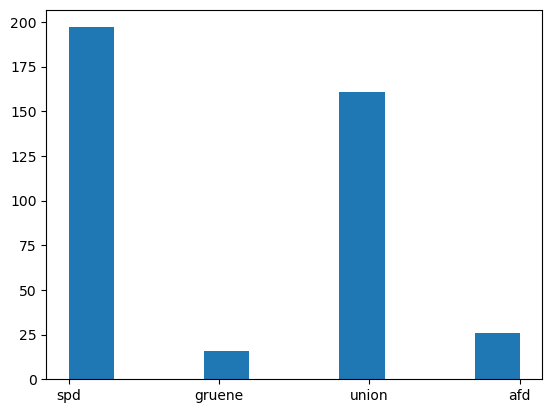

In [95]:
#to get a brief understanding of the data, I will provide some basic descriptive statistics
#frequency of how many districts each party could win
#for those who are familiar with the german political landscape
#it is probably not so surprising to see union and spd winnig a lot
#while the green party and afd won only few
#linke and fdp even zero (linke won some, but only some constituencies in bigger cities)
plt.hist(df.win)

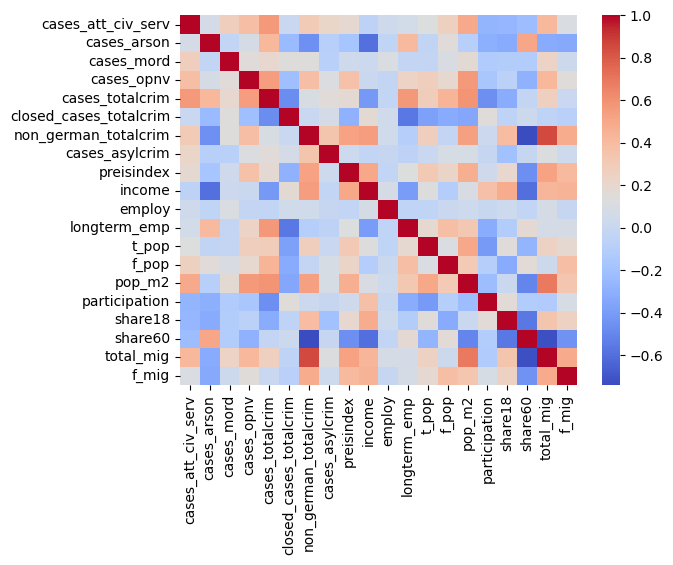

In [96]:
#this heatmap gives a rough overview how the independent variables are
#correlated
#most of variables are moderately correlated
#interestingly higher migration share and crime cmomitted by non-germans 
#corresponds to lower share of old people
#crime committed by non-germans is positively correlated with migration
df_values=df.drop(['win'], axis=1)
corr_matrix = df_values.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

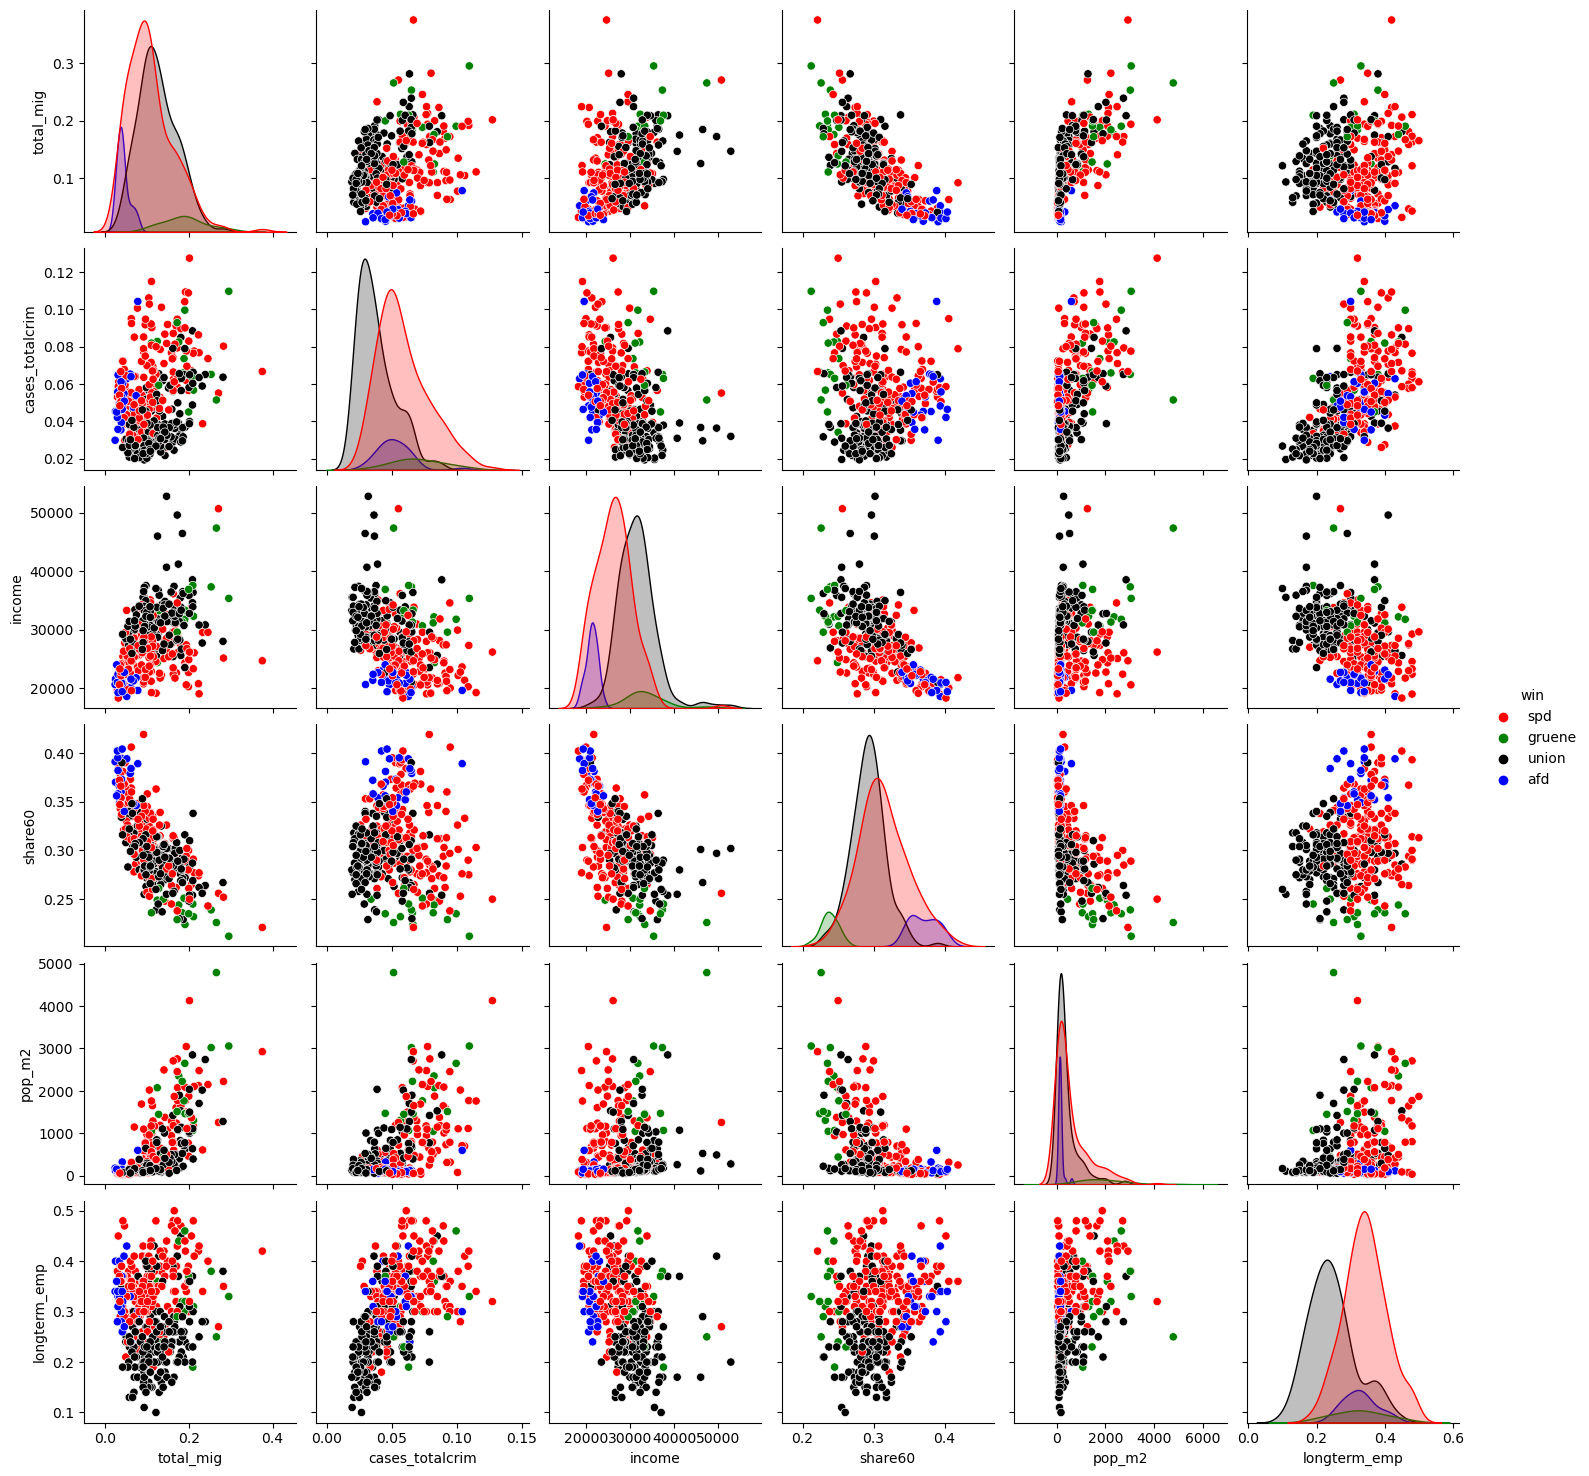

In [97]:
#this pairplot reveals some interesting deeper relationships based on
#the class label
#it shows us, that the target group of afd and green party are the most 
#contrary regarding migration, income, age, population density
#spd and union differ by income, employment and crimerates
my_palette = {"union": "black", "spd": "red", "afd": "blue", "gruene": "green"}
sns.pairplot(df, vars=['total_mig', 'cases_totalcrim','income','share60','pop_m2','longterm_emp'], hue='win', palette=my_palette)
plt.show()

In [98]:
#for better comparability I will normalize the data
for column in df.drop(['win'], axis=1).columns[:-1]:   
    col = df[column]
    max = col.max()
    min = col.min()
    df[column] = (col**0.5 - min**0.5) / (max**0.5 - min**0.5)

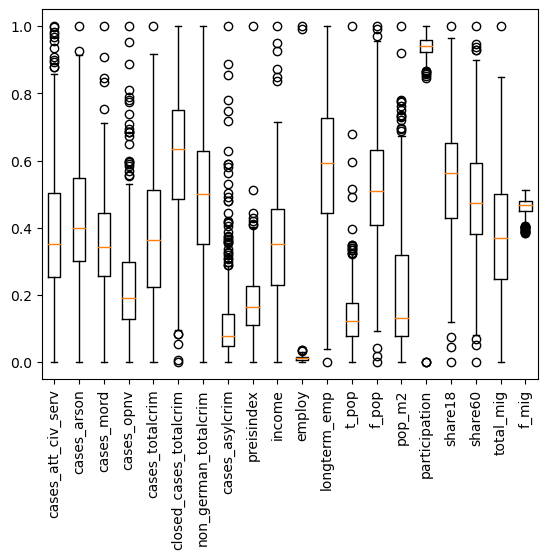

In [99]:
#the boxplots gives us more information about the distribution
#asyl crime seems to be very low in general but where it occurs it is pretty bundled
#also total employment seems to be very high, with a few outliers 
#with extremely low employment rate
plt.boxplot(df.drop(['win'],axis=1).values, labels=df.drop(['win'],axis=1).columns)
plt.xticks(rotation=90)
plt.show()

In [100]:
#splitting the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['win'], train_size=0.8, test_size=0.2, random_state=42)

In [101]:
#I will apply different algorithms to classify the winning party
#support vector machines
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
svm = SVC()
svm.fit(X_train, y_train)
predicts_svm = svm.predict(X_test)
print(classification_report(y_test, predicts_svm))

              precision    recall  f1-score   support

         afd       0.67      0.67      0.67         3
      gruene       0.00      0.00      0.00         3
         spd       0.89      0.93      0.91        42
       union       0.84      0.84      0.84        32

    accuracy                           0.85        80
   macro avg       0.60      0.61      0.60        80
weighted avg       0.83      0.85      0.84        80



In [102]:
#k-nearest neighbor
knn = neighbors.KNeighborsClassifier(n_neighbors=8).fit(X_train, y_train)
predicts_knn = knn.predict(X_test)
print(classification_report(y_test, predicts_knn))

              precision    recall  f1-score   support

         afd       0.75      1.00      0.86         3
      gruene       1.00      0.33      0.50         3
         spd       0.84      0.86      0.85        42
       union       0.81      0.81      0.81        32

    accuracy                           0.82        80
   macro avg       0.85      0.75      0.75        80
weighted avg       0.83      0.82      0.82        80



In [103]:
#naive bayes classifier
nb = naive_bayes.GaussianNB().fit(X_train, y_train)
predicts_nb = nb.predict(X_test)
print(classification_report(y_test, predicts_nb))

              precision    recall  f1-score   support

         afd       0.38      1.00      0.55         3
      gruene       0.75      1.00      0.86         3
         spd       0.82      0.79      0.80        42
       union       0.82      0.72      0.77        32

    accuracy                           0.78        80
   macro avg       0.69      0.88      0.74        80
weighted avg       0.80      0.78      0.78        80



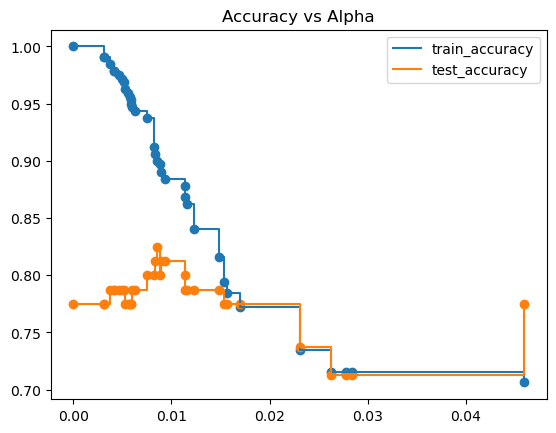

In [104]:
#decision tree
tr = tree.DecisionTreeClassifier().fit(X_train, y_train)
#post pruning to overcome problem of overfitting
path = tr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
trees = []
for ccp_alpha in ccp_alphas:
    tr = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tr.fit(X_train, y_train)
    trees.append(tr)
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

train_acc = []
test_acc = []
for t in trees:
    y_train_pred = t.predict(X_train)
    y_test_pred = t.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs Alpha')
plt.show()

In [105]:
#0.009 seems to be a fitting alpha
tr_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.009)
tr_.fit(X_train,y_train)
predicts_tr_ = tr_.predict(X_test)
print(classification_report(y_test, predicts_tr_))

              precision    recall  f1-score   support

         afd       0.67      0.67      0.67         3
      gruene       1.00      1.00      1.00         3
         spd       0.81      0.83      0.82        42
       union       0.81      0.78      0.79        32

    accuracy                           0.81        80
   macro avg       0.82      0.82      0.82        80
weighted avg       0.81      0.81      0.81        80



In [106]:
#neural network
X = df.drop('win', axis=1)
y = df['win']
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train_nn = torch.tensor(X_train_nn.values).float()
X_test_nn = torch.tensor(X_test_nn.values).float()
y_train_nn = torch.tensor(y_train_nn.argmax(axis=1)).long()
y_test_nn = torch.tensor(y_test_nn.argmax(axis=1)).long()

#define the neural network architecture
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(20, 10)
        self.fc2 = torch.nn.Linear(10, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#train the neural network
net = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = net(X_train_nn)
    loss = criterion(outputs, y_train_nn)
    loss.backward()
    optimizer.step()

#test the neural network
with torch.no_grad():
    outputs = net(X_test_nn)
    predicts_nn = torch.argmax(outputs, dim=1)
    accuracy_nn = (predicts_nn == y_test_nn).sum().item()/len(y_test_nn)
accuracy_nn

/Users/timoloos/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.7875

In [107]:
#compare the accuracy
print('Accuracy SVM: ', accuracy_score(svm.predict(X_test), y_test))
print('Accuracy KNN: ', accuracy_score(knn.predict(X_test), y_test))
print('Accuracy NB: ', accuracy_score(nb.predict(X_test), y_test))
print('Accuracy TR: ', accuracy_score(tr_.predict(X_test), y_test))
print('Accuracy NN: ', accuracy_nn)

Accuracy SVM:  0.85
Accuracy KNN:  0.825
Accuracy NB:  0.775
Accuracy TR:  0.8125
Accuracy NN:  0.7875
